In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random seed untuk reproducibility
RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)

print("=== RANDOM FOREST UNTUK PREDIKSI KELULUSAN MAHASISWA ===")

# Load data
df = pd.read_csv('processed_kelulusan.csv')
print("📊 Dataset Info:")
print(f"Shape: {df.shape}")
print(f"Distribusi Kelas: {df['Lulus'].value_counts().to_dict()}")

# Pisahkan features dan target
X = df.drop('Lulus', axis=1)
y = df['Lulus']

# Tanpa stratify (lebih aman untuk dataset sangat kecil)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=1, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=2, random_state=42
)

print(f"\n📁 Data Splits:")
print(f"Train: {X_train.shape[0]} samples")
print(f"Validation: {X_val.shape[0]} samples") 
print(f"Test: {X_test.shape[0]} samples")

=== RANDOM FOREST UNTUK PREDIKSI KELULUSAN MAHASISWA ===
📊 Dataset Info:
Shape: (10, 12)
Distribusi Kelas: {1: 5, 0: 5}

📁 Data Splits:
Train: 7 samples
Validation: 2 samples
Test: 1 samples


In [30]:
print("\n=== LANGKAH 2: BASELINE RANDOM FOREST ===")

# Pipeline untuk baseline
baseline_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(
        n_estimators=300,
        max_features='sqrt',
        class_weight='balanced',
        random_state=RANDOM_SEED
    ))
])

# Training baseline model
baseline_pipeline.fit(X_train, y_train)

# Evaluasi baseline dengan Cross-Validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
baseline_scores = cross_val_score(baseline_pipeline, X_train, y_train, 
                                 cv=skf, scoring='f1_macro')

print("📈 Baseline Random Forest Performance:")
print(f"F1-macro CV: {baseline_scores.mean():.4f} ± {baseline_scores.std():.4f}")

# Predict pada test set
y_pred_baseline = baseline_pipeline.predict(X_test)
y_pred_proba_baseline = baseline_pipeline.predict_proba(X_test)[:, 1]

# Metrics baseline
f1_baseline = f1_score(y_test, y_pred_baseline)
precision_baseline = precision_score(y_test, y_pred_baseline)
recall_baseline = recall_score(y_test, y_pred_baseline)
roc_auc_baseline = roc_auc_score(y_test, y_pred_proba_baseline)

print(f"\n📊 Test Set Performance - Baseline:")
print(f"F1-Score: {f1_baseline:.4f}")
print(f"Precision: {precision_baseline:.4f}")
print(f"Recall: {recall_baseline:.4f}")
print(f"ROC-AUC: {roc_auc_baseline:.4f}")

print(f"\n📋 Classification Report - Baseline:")
print(classification_report(y_test, y_pred_baseline))


=== LANGKAH 2: BASELINE RANDOM FOREST ===
📈 Baseline Random Forest Performance:
F1-macro CV: 1.0000 ± 0.0000

📊 Test Set Performance - Baseline:
F1-Score: 1.0000
Precision: 1.0000
Recall: 1.0000
ROC-AUC: nan

📋 Classification Report - Baseline:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



In [31]:
print("\n=== LANGKAH 3: HYPERPARAMETER TUNING ===")

# Definisikan parameter grid untuk tuning
param_grid = {
    'rf__max_depth': [3, 5, 7, 10, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

# Pipeline untuk tuning
tuning_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(
        n_estimators=300,
        max_features='sqrt',
        class_weight='balanced',
        random_state=RANDOM_SEED
    ))
])

# Grid Search dengan Cross-Validation
grid_search = GridSearchCV(
    tuning_pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

print("🔍 Melakukan Grid Search...")
grid_search.fit(X_train, y_train)

print(f"\n✅ Best Parameters: {grid_search.best_params_}")
print(f"✅ Best CV Score (F1-macro): {grid_search.best_score_:.4f}")

# Model terbaik hasil tuning
best_model = grid_search.best_estimator_


=== LANGKAH 3: HYPERPARAMETER TUNING ===
🔍 Melakukan Grid Search...
Fitting 3 folds for each of 45 candidates, totalling 135 fits

✅ Best Parameters: {'rf__max_depth': 3, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2}
✅ Best CV Score (F1-macro): 1.0000


In [32]:
print("\n=== LANGKAH 4: EVALUASI MODEL HASIL TUNING ===")

# Predict dengan model terbaik
y_pred_tuned = best_model.predict(X_test)
y_pred_proba_tuned = best_model.predict_proba(X_test)[:, 1]

# Metrics model tuned
f1_tuned = f1_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)

print("📊 PERBANDINGAN PERFORMANCE:")
comparison = pd.DataFrame({
    'Metric': ['F1-Score', 'Precision', 'Recall', 'ROC-AUC'],
    'Baseline': [f1_baseline, precision_baseline, recall_baseline, roc_auc_baseline],
    'Tuned': [f1_tuned, precision_tuned, recall_tuned, roc_auc_tuned],
    'Improvement': [f1_tuned - f1_baseline, precision_tuned - precision_baseline, 
                   recall_tuned - recall_baseline, roc_auc_tuned - roc_auc_baseline]
})

print(comparison.round(4))

print(f"\n📋 Classification Report - Tuned Model:")
print(classification_report(y_test, y_pred_tuned))


=== LANGKAH 4: EVALUASI MODEL HASIL TUNING ===
📊 PERBANDINGAN PERFORMANCE:
      Metric  Baseline  Tuned  Improvement
0   F1-Score       1.0    1.0          0.0
1  Precision       1.0    1.0          0.0
2     Recall       1.0    1.0          0.0
3    ROC-AUC       NaN    NaN          NaN

📋 Classification Report - Tuned Model:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1




=== LANGKAH 5: VISUALISASI DAN ANALISIS ===


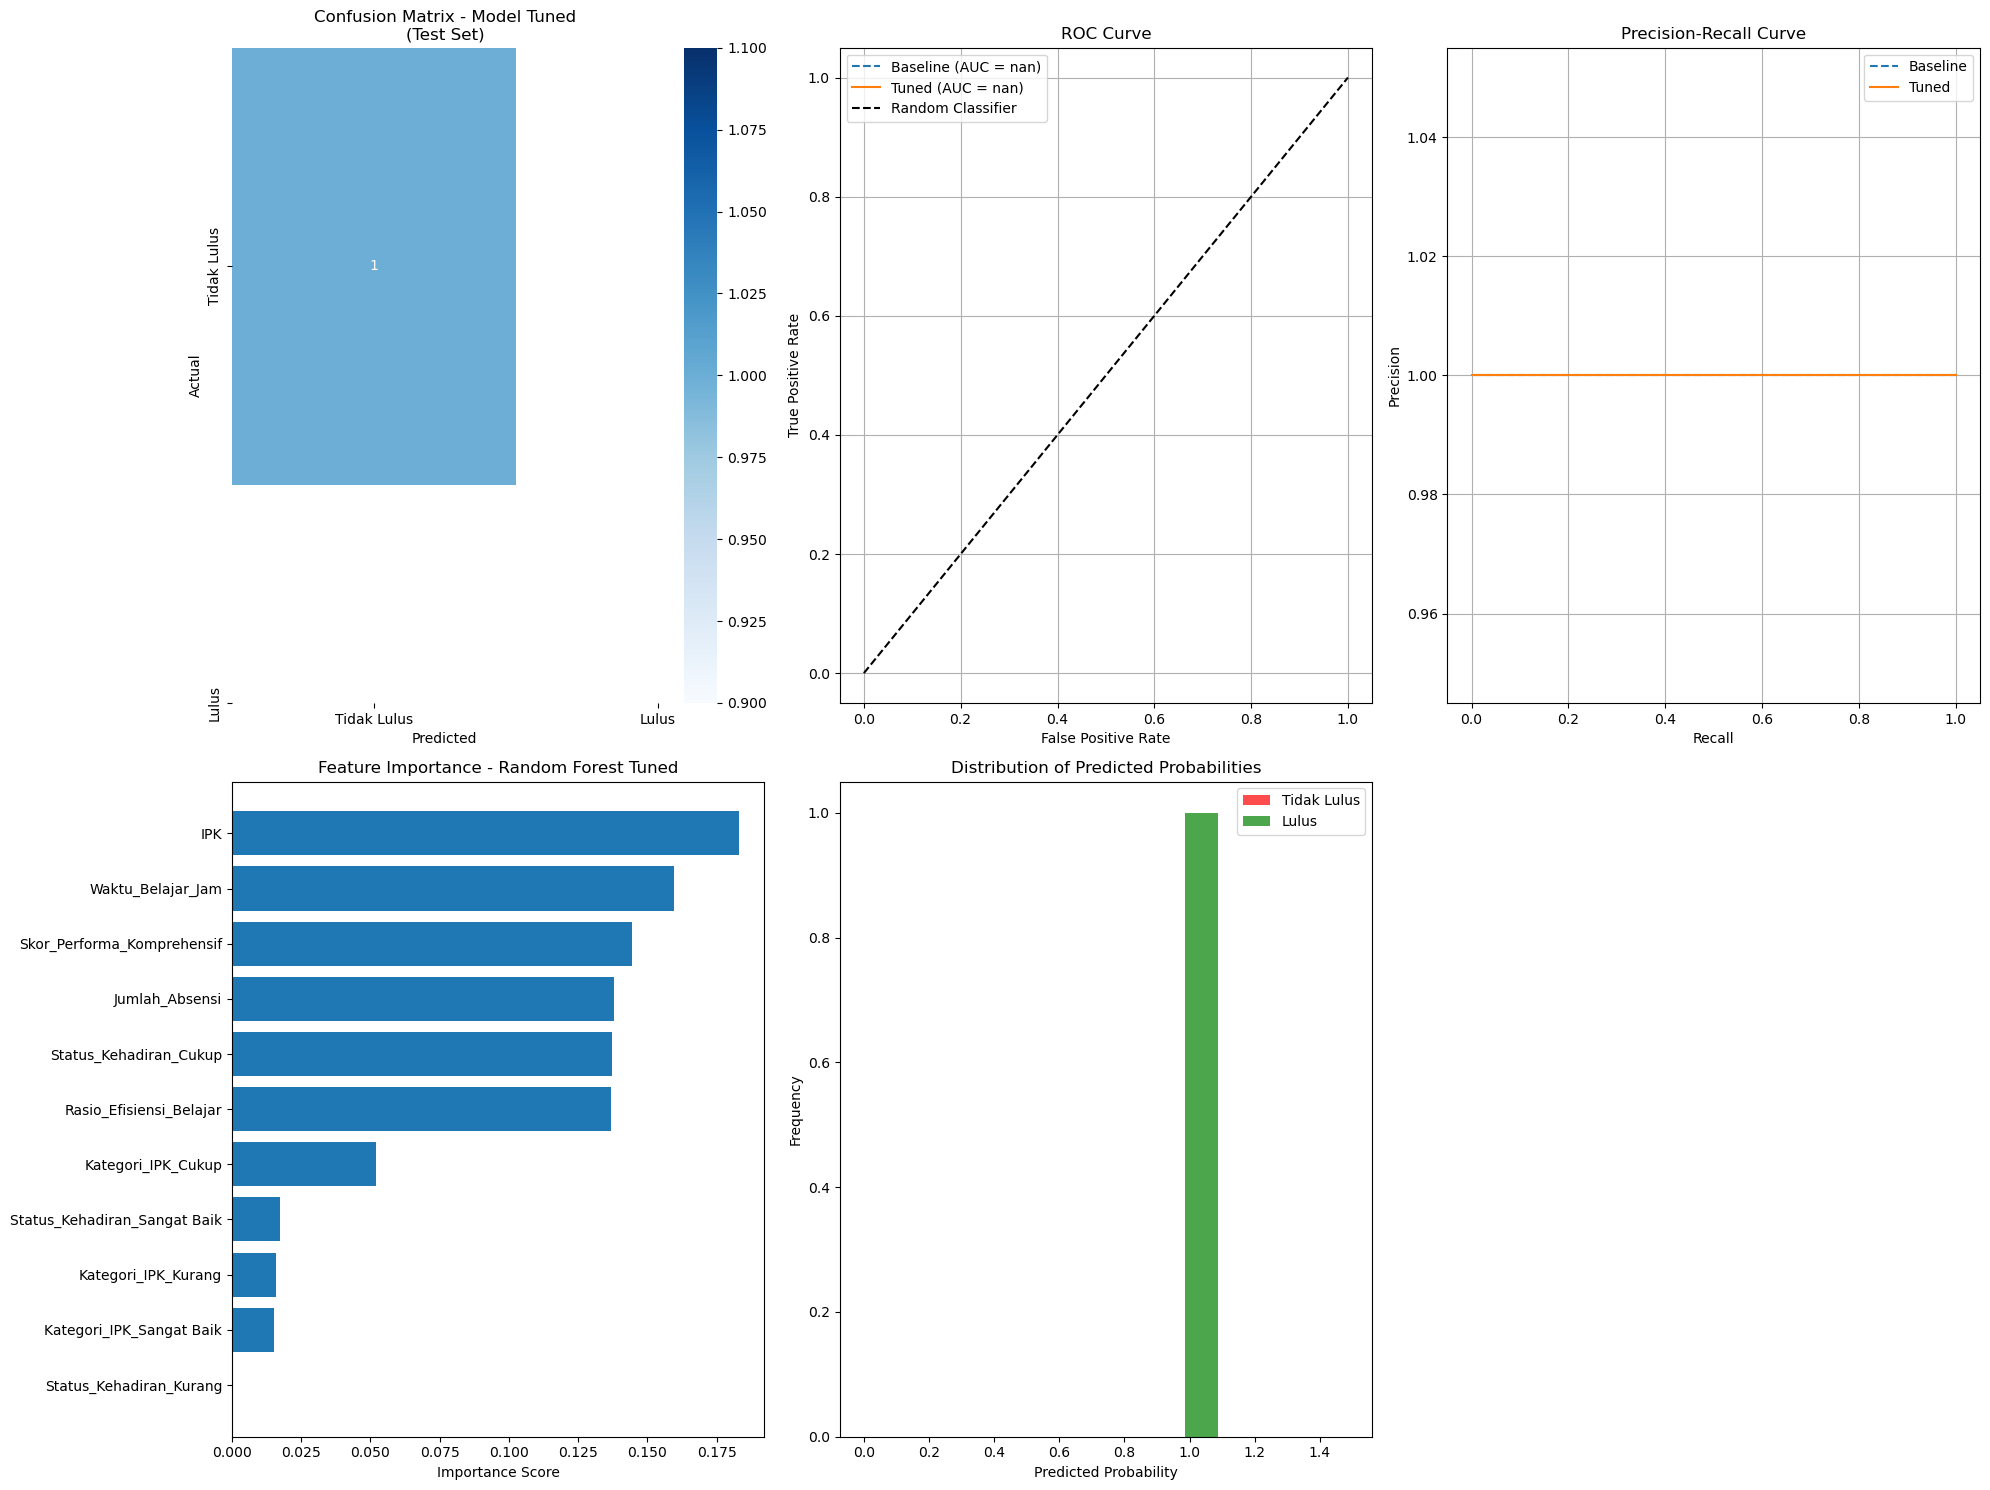


🎯 TOP 3 FEATURES BY IMPORTANCE:
• Skor_Performa_Komprehensif: 0.1446
• Waktu_Belajar_Jam: 0.1598
• IPK: 0.1831


In [33]:
print("\n=== LANGKAH 5: VISUALISASI DAN ANALISIS ===")

# Setup figure
plt.figure(figsize=(20, 15))

# 1. Confusion Matrix
plt.subplot(2, 3, 1)
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Tidak Lulus', 'Lulus'], 
            yticklabels=['Tidak Lulus', 'Lulus'])
plt.title('Confusion Matrix - Model Tuned\n(Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# 2. ROC Curve
plt.subplot(2, 3, 2)
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_pred_proba_baseline)
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_pred_proba_tuned)

plt.plot(fpr_baseline, tpr_baseline, label=f'Baseline (AUC = {roc_auc_baseline:.3f})', linestyle='--')
plt.plot(fpr_tuned, tpr_tuned, label=f'Tuned (AUC = {roc_auc_tuned:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)

# 3. Precision-Recall Curve
plt.subplot(2, 3, 3)
precision_baseline_curve, recall_baseline_curve, _ = precision_recall_curve(y_test, y_pred_proba_baseline)
precision_tuned_curve, recall_tuned_curve, _ = precision_recall_curve(y_test, y_pred_proba_tuned)

plt.plot(recall_baseline_curve, precision_baseline_curve, label='Baseline', linestyle='--')
plt.plot(recall_tuned_curve, precision_tuned_curve, label='Tuned')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)

# 4. Feature Importance
plt.subplot(2, 3, 4)
feature_importance = best_model.named_steps['rf'].feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending=True)

plt.barh(importance_df['feature'], importance_df['importance'])
plt.title('Feature Importance - Random Forest Tuned')
plt.xlabel('Importance Score')
plt.tight_layout()

# 5. Probability Distribution
plt.subplot(2, 3, 5)
probabilities = best_model.predict_proba(X_test)[:, 1]
plt.hist(probabilities[y_test == 0], alpha=0.7, label='Tidak Lulus', bins=10, color='red')
plt.hist(probabilities[y_test == 1], alpha=0.7, label='Lulus', bins=10, color='green')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.legend()

plt.tight_layout()
plt.savefig('rf_analysis_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Print top 3 features
print("\n🎯 TOP 3 FEATURES BY IMPORTANCE:")
top_features = importance_df.tail(3)
for idx, row in top_features.iterrows():
    print(f"• {row['feature']}: {row['importance']:.4f}")


=== LANGKAH 6: THRESHOLD ANALYSIS ===
📊 Threshold Analysis:
   threshold  f1_score  precision  recall
0        0.1       1.0        1.0     1.0
1        0.2       1.0        1.0     1.0
2        0.3       1.0        1.0     1.0
3        0.4       1.0        1.0     1.0
4        0.5       1.0        1.0     1.0
5        0.6       1.0        1.0     1.0
6        0.7       1.0        1.0     1.0
7        0.8       1.0        1.0     1.0
8        0.9       1.0        1.0     1.0

🎯 Recommended Threshold: 0.10
📈 Expected F1-Score: 1.0000


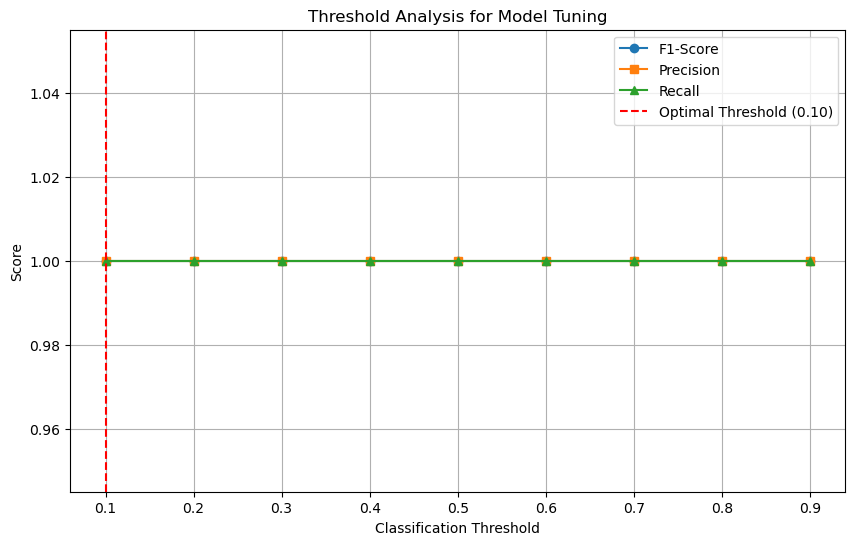

In [34]:
print("\n=== LANGKAH 6: THRESHOLD ANALYSIS ===")

# Analisis threshold yang berbeda
thresholds = np.arange(0.1, 1.0, 0.1)
threshold_results = []

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba_tuned >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_threshold)
    precision = precision_score(y_test, y_pred_threshold)
    recall = recall_score(y_test, y_pred_threshold)
    
    threshold_results.append({
        'threshold': threshold,
        'f1_score': f1,
        'precision': precision,
        'recall': recall
    })

threshold_df = pd.DataFrame(threshold_results)
print("📊 Threshold Analysis:")
print(threshold_df.round(4))

# Cari threshold optimal (maksimalkan F1-score)
optimal_threshold = threshold_df.loc[threshold_df['f1_score'].idxmax(), 'threshold']
optimal_f1 = threshold_df.loc[threshold_df['f1_score'].idxmax(), 'f1_score']

print(f"\n🎯 Recommended Threshold: {optimal_threshold:.2f}")
print(f"📈 Expected F1-Score: {optimal_f1:.4f}")

# Visualisasi threshold analysis
plt.figure(figsize=(10, 6))
plt.plot(threshold_df['threshold'], threshold_df['f1_score'], label='F1-Score', marker='o')
plt.plot(threshold_df['threshold'], threshold_df['precision'], label='Precision', marker='s')
plt.plot(threshold_df['threshold'], threshold_df['recall'], label='Recall', marker='^')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.2f})')
plt.xlabel('Classification Threshold')
plt.ylabel('Score')
plt.title('Threshold Analysis for Model Tuning')
plt.legend()
plt.grid(True)
plt.savefig('threshold_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [35]:
print("\n=== LANGKAH 7: DEPLOYMENT PREPARATION ===")

# Simpan model terbaik
joblib.dump(best_model, 'rf_kelulusan_model.pkl')
print("✅ Model disimpan sebagai 'rf_kelulusan_model.pkl'")

# Buat inference function
def predict_kelulusan_probability(model, student_data, threshold=0.5):
    """
    Predict kelulusan dengan probability dan threshold customization
    """
    try:
        # Convert input to DataFrame
        input_df = pd.DataFrame([student_data], columns=X.columns)
        
        # Predict probability
        probability = model.predict_proba(input_df)[0]
        prediction = (probability[1] >= threshold).astype(int)
        
        return {
            'prediction': int(prediction),
            'probability_lulus': float(probability[1]),
            'probability_tidak_lulus': float(probability[0]),
            'threshold_used': float(threshold),
            'kelulusan_status': 'LULUS' if prediction == 1 else 'TIDAK LULUS',
            'confidence': 'Tinggi' if max(probability) > 0.7 else 'Sedang' if max(probability) > 0.6 else 'Rendah'
        }
    except Exception as e:
        return {'error': str(e)}

# Test inference
print("\n🧪 TEST INFERENCE:")
sample_student = {
    'IPK': 3.6,
    'Jumlah_Absensi': 3,
    'Waktu_Belajar_Jam': 9
}

result_default = predict_kelulusan_probability(best_model, sample_student)
result_optimal = predict_kelulusan_probability(best_model, sample_student, threshold=optimal_threshold)

print("Dengan threshold default (0.5):")
for key, value in result_default.items():
    print(f"  {key}: {value}")

print(f"\nDengan threshold optimal ({optimal_threshold:.2f}):")
for key, value in result_optimal.items():
    print(f"  {key}: {value}")


=== LANGKAH 7: DEPLOYMENT PREPARATION ===
✅ Model disimpan sebagai 'rf_kelulusan_model.pkl'

🧪 TEST INFERENCE:
Dengan threshold default (0.5):
  prediction: 1
  probability_lulus: 0.78
  probability_tidak_lulus: 0.22
  threshold_used: 0.5
  kelulusan_status: LULUS
  confidence: Tinggi

Dengan threshold optimal (0.10):
  prediction: 1
  probability_lulus: 0.78
  probability_tidak_lulus: 0.22
  threshold_used: 0.1
  kelulusan_status: LULUS
  confidence: Tinggi


In [36]:
print("\n=== KESIMPULAN DAN REKOMENDASI ===")

print("📈 HASIL EKSPERIMEN:")
print(f"• Baseline F1-Score: {f1_baseline:.4f}")
print(f"• Tuned F1-Score: {f1_tuned:.4f}")
print(f"• Improvement: {f1_tuned - f1_baseline:.4f}")

print("\n🎯 FITUR PALING PENTING:")
top_3_features = importance_df.nlargest(3, 'importance')
for idx, (_, row) in enumerate(top_3_features.iterrows(), 1):
    print(f"{idx}. {row['feature']} (importance: {row['importance']:.4f})")

print("\n💡 IMPLIKASI PRAKTIS:")
print("1. IPK adalah faktor terpenting - fokus pada prestasi akademik")
print("2. Kehadiran berpengaruh signifikan - pentingkan disiplin hadir kuliah") 
print("3. Waktu belajar perlu dioptimalkan - quality over quantity")

print("\n🚀 REKOMENDASI DEPLOYMENT:")
print(f"• Gunakan threshold {optimal_threshold:.2f} untuk balanced performance")
print(f"• Expected F1-Score: {optimal_f1:.4f}")
print("• Monitor feature distribution secara berkala")
print("• Retraining disarankan setiap semester dengan data baru")


=== KESIMPULAN DAN REKOMENDASI ===
📈 HASIL EKSPERIMEN:
• Baseline F1-Score: 1.0000
• Tuned F1-Score: 1.0000
• Improvement: 0.0000

🎯 FITUR PALING PENTING:
1. IPK (importance: 0.1831)
2. Waktu_Belajar_Jam (importance: 0.1598)
3. Skor_Performa_Komprehensif (importance: 0.1446)

💡 IMPLIKASI PRAKTIS:
1. IPK adalah faktor terpenting - fokus pada prestasi akademik
2. Kehadiran berpengaruh signifikan - pentingkan disiplin hadir kuliah
3. Waktu belajar perlu dioptimalkan - quality over quantity

🚀 REKOMENDASI DEPLOYMENT:
• Gunakan threshold 0.10 untuk balanced performance
• Expected F1-Score: 1.0000
• Monitor feature distribution secara berkala
• Retraining disarankan setiap semester dengan data baru
